In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm
import pathlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams['figure.figsize'] = (16,9)

In [4]:
# p = pathlib.Path('../cluster/results/')
# path = pathlib.Path('../longrun_new/')
# path = pathlib.Path('../cluster/long_run_4000/')
path = pathlib.Path('../results/')

In [5]:
spikes_ex, spikes_in = [], []
for f in path.iterdir():
    if f.suffix == '.gdf':
        df = pd.read_csv(
            f, sep='\t', header=None).rename(columns={0:'sender', 1:'times'}).drop(columns=2)
        if f.stem.startswith('ex'):
            spikes_ex.append(df)
        else:
            spikes_in.append(df)
            
spikes_ex = pd.concat(spikes_ex)
spikes_in = pd.concat(spikes_in)

In [6]:
stim_data = np.load(path / 'stimulation_data_0.npz', allow_pickle=True)['data'][()]
stim_times = np.array(stim_data['times'])
stim_durations = np.array(stim_data['durations'])

In [7]:
spiketrains_ex = spikes_ex.groupby('sender')
spiketrains_in = spikes_in.groupby('sender')

In [8]:
import json
with open(str(path / 'params.json'), 'r') as f:
    params = json.load(f)

t_stop = params['status']['time']

In [16]:
conn = pd.concat([pd.read_feather(p) for p in path.iterdir() if p.suffix == '.feather'])

In [10]:
conn.loc[:,'source_stimulated'] = conn.source.isin(stim_data['stim_nodes']['ex'])
conn.loc[:,'target_stimulated'] = conn.target.isin(stim_data['stim_nodes']['ex'])
conn.loc[:,'target_ex'] = conn.target.isin(spikes_ex.sender.unique())
conn['stim_amp_source'] = conn.progress_apply(
    lambda x: stim_data['stim_amps']['ex'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=397514), HTML(value='')))

In [17]:
conn

,weight,source,target
0,0.179494,1,487
1,0.003828,1,1479
2,0.073643,1,1712
3,0.110721,1,1493
4,0.192410,1,3198
5,0.063460,1,1479
6,0.089460,1,312
7,0.037755,1,488
8,0.062575,1,2719
9,0.102499,1,1131


In [11]:
np.unique(np.diff(stim_times))

array([211.7, 220.4, 228.4, 258.8])

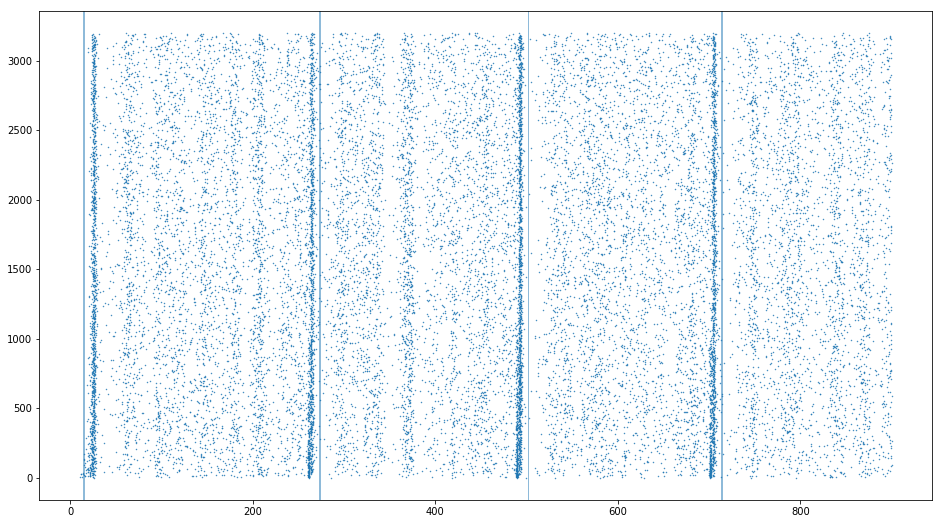

In [14]:
t1, t2 = 0, 900

mask = (spikes_ex.times >= t1) & (spikes_ex.times <= t2)
mask_s = (stim_times >= t1) & (stim_times <= t2)

plt.scatter(spikes_ex.times[mask], spikes_ex.sender[mask], s=.2)
# plt.xlim(590,640)
for s, d in zip(stim_times[mask_s], stim_durations[mask_s]):
    plt.axvspan(s, s+d, alpha=.5)

In [13]:
stim_times

array([ 13.8, 272.6, 501. , 712.7, 933.1])

In [ ]:
t1, t2 = 600, 650

mask = (spikes_in.times >= t1) & (spikes_in.times <= t2)
mask_s = (stim_times >= t1) & (stim_times <= t2)

plt.scatter(spikes_in.times[mask], spikes_in.sender[mask], s=.2)
# plt.xlim(590,640)
for s, d in zip(stim_times[mask_s], stim_durations[mask_s]):
    plt.axvspan(s, s+d, alpha=.5)

In [60]:
start_ai = 100
stop_ai = 600
duration = stop_ai - start_ai

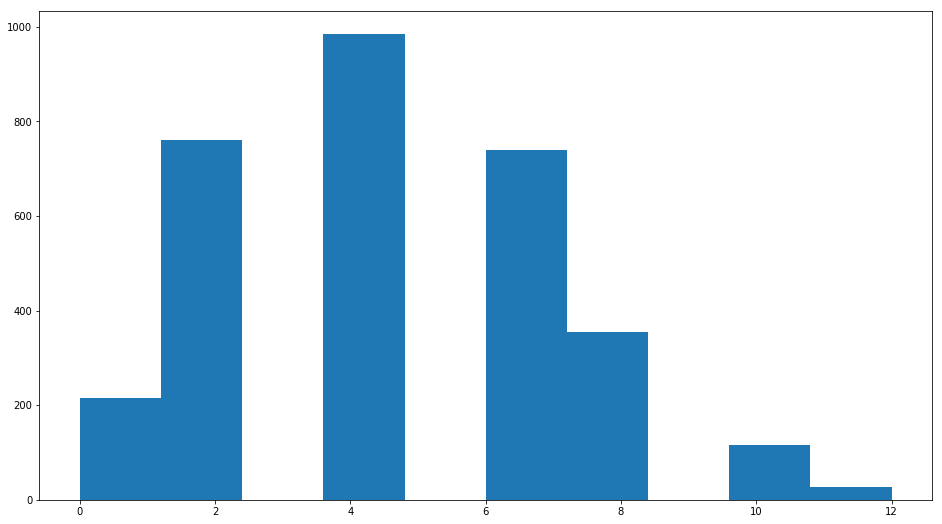

In [61]:
plt.hist([len(s.times[(s.times > start_ai) & (s.times < stop_ai)]) / (duration / 1000) 
          for i, s in spiketrains_ex]);

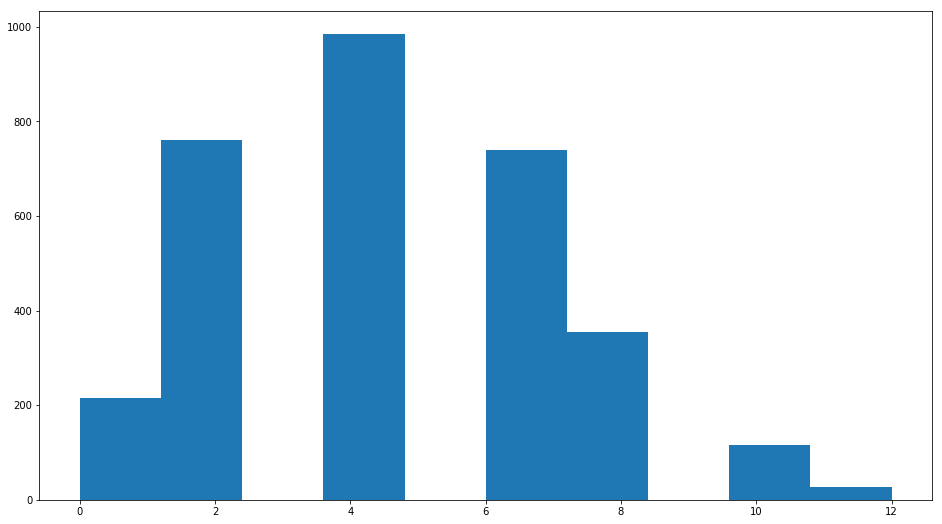

In [62]:
plt.hist([len(s.times[(s.times > start_ai) & (s.times < stop_ai)]) / (duration / 1000) 
          for i, s in spiketrains_ex]);

../tools_analysis.py:73: RuntimeWarning: invalid value encountered in true_divide
  mat = [(m - m.mean()) / m.std() for m in [a, b]]


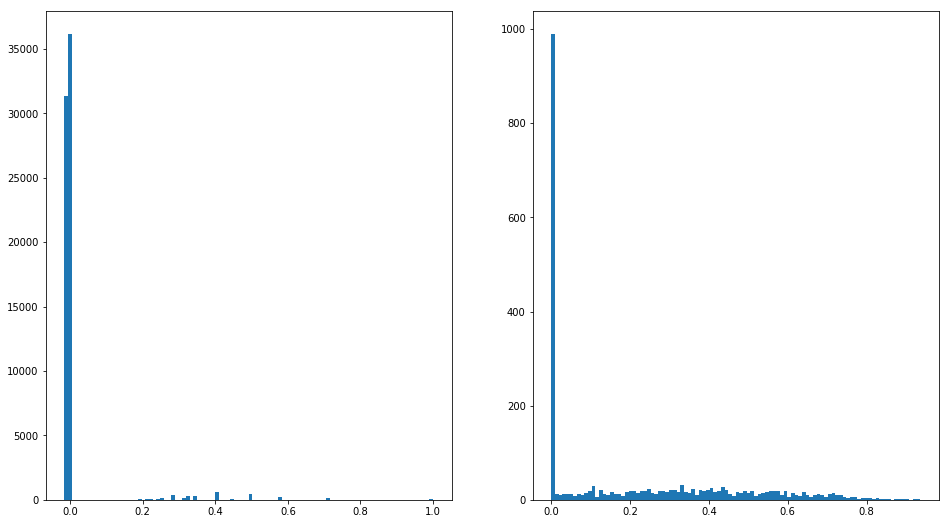

In [63]:
fig, ax = plt.subplots(1, 2)


binsize_corr = 2.
spiketrains_list = [
    s.times[(s.times > start_ai) & (s.times < stop_ai)] for i, s in spiketrains_ex
]

cc = corrcoef(
    np.random.choice(spiketrains_list, 400), t_stop, binsize=binsize_corr)

cc = cc[np.triu_indices(len(cc), k=1)]
cc = cc[~np.isnan(cc)]
ax[0].hist(cc, bins=100);


cv = np.array(coef_var(spiketrains_list))
cv = cv[~np.isnan(cv)]

ax[1].hist(cv, bins=100);

Text(0.5,0,'Hit rate')

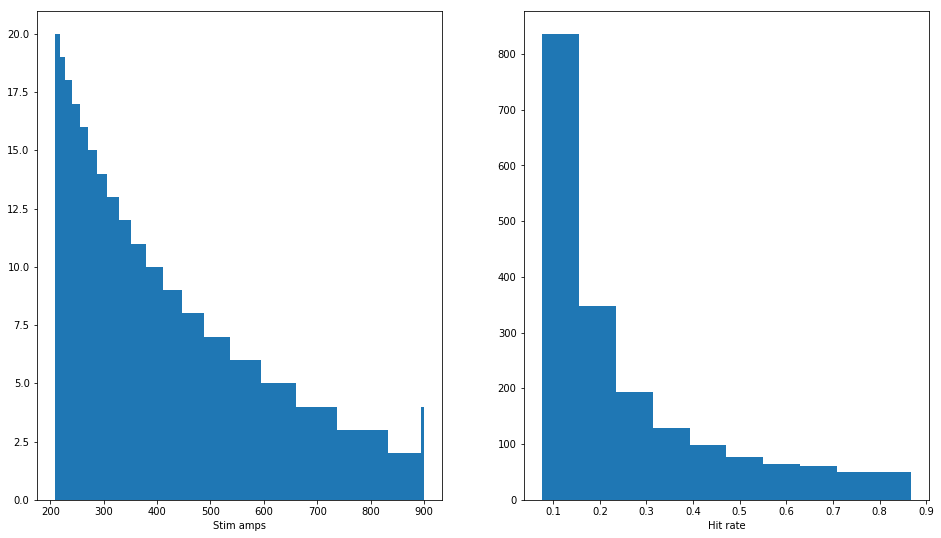

In [48]:
mu = 2
sigma = 1
hit_rates = [hit_rate(s.times, stim_times,  mu=mu, sigma=sigma)
             for i, s in spiketrains_ex if s.sender.iloc[0] in stim_data['stim_nodes']['ex']]


fig, ax = plt.subplots(1, 2)

amps = np.array(list(stim_data['stim_amps']['ex'].values()))
ax[0].hist(amps, bins=np.unique(amps))
ax[0].set_xlabel('Stim amps')

ax[1].hist(hit_rates)
ax[1].set_xlabel('Hit rate')

In [103]:
from causal_optoconnectics.core import raised_cosine
import statsmodels.api as sm
from linearmodels.iv import IV2SLS


# def continuous_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases, bin_size, offset):

#     stim_times = stim_times.astype(float)

#     src_x = np.searchsorted(x, stim_times, side='right')
#     remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
#     src_x = np.delete(src_x, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)
#     Z = x[src_x-1] - stim_times
#     X = x[src_x] - stim_times

#     stim_win = np.insert(
#         stim_times + y_mu - y_sigma,
#         np.arange(len(stim_times)) + 1,
#         stim_times + y_mu + y_sigma)
#     src_y = np.searchsorted(y, stim_win, side='left')
#     cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
#     Y = cnt_y.flatten()
    
#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
#     try:
#         res = model.fit()
#         beta = res.params[0]
#     except:
#         beta = np.nan
#     return beta

#     return beta


def calculate_regressors(x, y, stim_times):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_y==len(y)))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Y = y[src_y] - stim_times
    Z = x[src_x-1] - stim_times

    return Z, X, Y, stim_times


# def logit_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma):
    
#     _, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    
#     if not any(np.diff(X)): # logit solver needs two classes
#         return np.nan
    
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     model = LogisticRegression(C=1e5, solver='liblinear')
#     model.fit(X.reshape(-1,1), Y)

#     prob = model.predict_proba([[1], [0]])[:,0]
#     beta = float(np.diff(prob))

#     return beta


# def logit_instrument_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, n_bases, bin_size, offset):
    
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    
#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
# #     Z = (Z < cutoff).astype(int).reshape(-1,1)

#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    
#     model = LogisticRegression(C=1e5, solver='liblinear')
#     model.fit(Z, X)

#     X = model.predict(Z)
    
#     if not any(np.diff(X)): # logit solver needs two classes
#         return np.nan
    
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     model = LogisticRegression(C=1e5, solver='liblinear')
#     model.fit(X.reshape(-1,1), Y)

#     prob = model.predict_proba([[1], [0]])[:,0]
#     beta = float(np.diff(prob))

#     return beta


# def wald_instrument_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, cutoff):
    
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)                                                                                                         
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
#     Z = (abs(Z) < cutoff).astype(int)
#     return (Y[Z==1].mean() - Y[Z==0].mean()) / (X[Z==1].mean() - X[Z==0].mean())


# def wald(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, cutoff):
#     stim_times = stim_times.astype(float)

#     src_x = np.searchsorted(x, stim_times, side='right')
#     remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
#     src_x = np.delete(src_x, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)
#     Z = x[src_x-1] - stim_times

#     stim_win = np.insert(
#         stim_times + y_mu - y_sigma,
#         np.arange(len(stim_times)) + 1,
#         stim_times + y_mu + y_sigma)
#     src_y = np.searchsorted(y, stim_win, side='left')
#     cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
#     Y = cnt_y.flatten() / (2 * y_sigma)
    
#     stim_win = np.insert(
#         stim_times + x_mu - x_sigma,
#         np.arange(len(stim_times)) + 1,
#         stim_times + x_mu + x_sigma)
#     src_x = np.searchsorted(x, stim_win, side='left')
#     cnt_x = np.diff(src_x.reshape((int(len(src_x) / 2), 2)))
#     X = cnt_x.flatten() / (2 * x_sigma)

#     Z = (abs(Z) < cutoff).astype(int)
#     return (Y[Z==1].mean() - Y[Z==0].mean()) / (X[Z==1].mean() - X[Z==0].mean())


# def cond_prob_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, cutoff):
    
#     _, X, Y, stim_times = calculate_regressors(x, y, stim_times)
#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)                                                                                                         
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
#     return Y[X==1].mean() - Y[X==0].mean()


def wald_density(x, y, stim_times, x1, x2, y1, y2, z1):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_y==len(y)))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Y = y[src_y] - stim_times
    Z = x[src_x-1] - stim_times
    Yn = y[src_y-1] - stim_times
    
    XX = ((X > x1) & (X < x2)).astype(int)
    ZZ = (abs(Z) < z1).astype(int)
    assert sum(XX[ZZ==1]) == 0
    X0 = np.concatenate([Z[ZZ==0], X[ZZ==0]])
    X1 = np.concatenate([Z[ZZ==1], X[ZZ==1]])
    Y0 = np.concatenate([Yn[ZZ==0], Y[ZZ==0]])
    Y1 = np.concatenate([Yn[ZZ==1], Y[ZZ==1]])
    
    binsize = .1
    bins = np.arange(-10, 10, binsize)
    density=True
    X0, _ = np.histogram(X0, bins=bins, density=density)
    X1, _ = np.histogram(X1, bins=bins, density=density)
    Y0, _ = np.histogram(Y0, bins=bins, density=density)
    Y1, _ = np.histogram(Y1, bins=bins, density=density)
    bins = bins[1:]# + binsize / 2

    plt.bar(bins, Y1, align='edge', width=-binsize, label='Y,Z=1', alpha=.5)
    plt.bar(bins, Y0, align='edge', width=-binsize, label='Y,Z=0', alpha=.5)
#     plt.bar(bins, X1, align='edge', width=-binsize, label='X,Z=1', alpha=.5)
    plt.bar(bins, X0, align='edge', width=-binsize, label='X,Z=0', alpha=.5)
    for l in [x1,x2,y1,y2,-z1]:
        plt.axvline(l)
    plt.legend()
    
    ev = lambda x: np.trapz(x, dx=binsize)
    assert abs(ev(X0) - 1) < 1e-2, ev(X0)
    
    mask_y = (bins >= y1) & (bins <= y2)
    mask_x = (bins >= x1) & (bins <= x2)
    Y11 = ev(Y1[mask_y]) / len(mask_y)
    Y10 = ev(Y0[mask_y]) / len(mask_y)
    X10 = ev(X0[mask_x]) / len(mask_y)
    
    mask_y = (bins >= -y1) & (bins <= -y2)
    mask_x = (bins >= -x1) & (bins <= -x2)
    Y01 = ev(Y1[mask_y]) / len(mask_y)
    Y00 = ev(Y0[mask_y]) / len(mask_y)
    X00 = ev(X0[mask_x]) / len(mask_y)
    
    return ((Y11 - Y01) - (Y10 - Y00)) / - (X10 - X00)

In [81]:
N=50
trials = [len(stim_data['epoch']['times'])]

sample = conn.query('stim_amp_source > 600 and stim_amp_source < 800 and weight > 0 and not target_stimulated and target_ex').sample(n=int(N / 2))
print(sample.weight.max())

2.1653446669987675


In [82]:
sample.sort_values('weight', ascending=False).head()

,weight,source,target,source_stimulated,target_stimulated,target_ex,stim_amp_source
69,2.165345,49,3110,True,False,True,795.573382
205,1.129703,163,2297,True,False,True,636.555981
83,1.111708,63,2713,True,False,True,769.142216
118,1.040930,99,3191,True,False,True,711.686301
240,0.965610,197,3054,True,False,True,607.964338


In [94]:
source, target, nosource= 49, 3110, 163

A = spiketrains_ex.get_group(source)['times'].to_numpy()
C = spiketrains_ex.get_group(target)['times'].to_numpy()
B = spiketrains_ex.get_group(nosource)['times'].to_numpy()
assert target not in sample.loc[sample.source==nosource].target

In [95]:
assert np.array_equal(Y_B, Y_A)
assert not np.array_equal(X_B, X_A)

0.023370940286728977

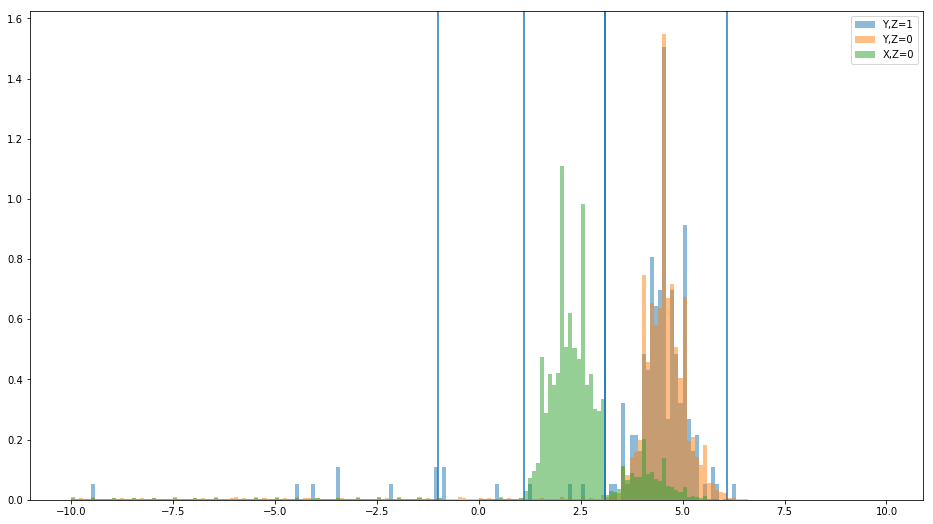

In [104]:
wald_density(A, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 1)

0.04710057583197312

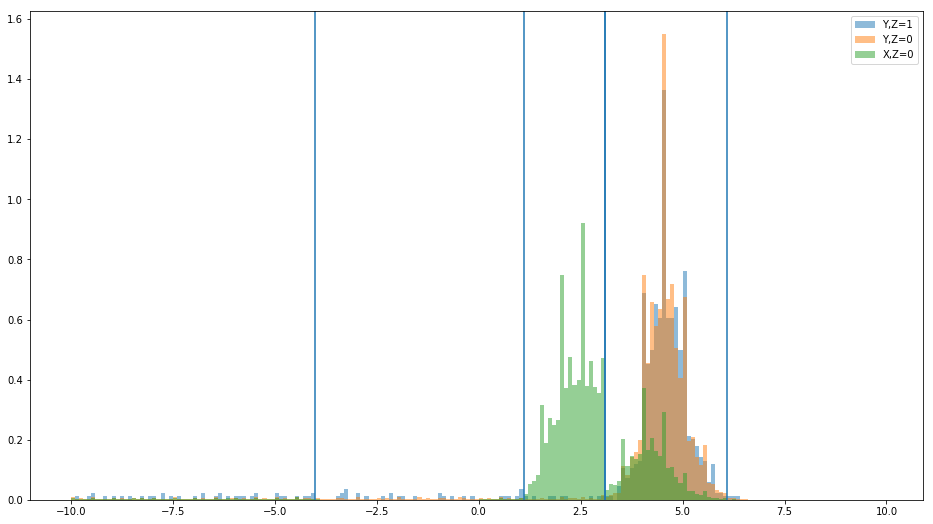

In [107]:
wald_density(B, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 4)


In [241]:
cutoff = 10
np.cov((abs(Z_A) < cutoff).astype(int), (abs(Z_B) < cutoff).astype(int))[0,1]
# np.corrcoef((abs(Z_A) < cutoff).astype(int), (abs(Z_B) < cutoff).astype(int))[0,1]

0.00020590008428691606

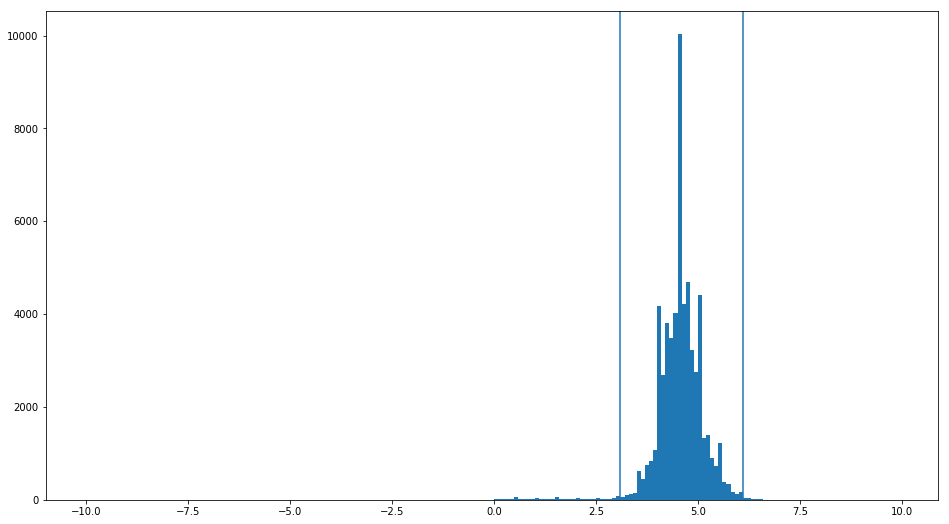

In [242]:
plt.hist(Y_A, bins=np.arange(-10,10,.1));
# plt.hist(X, bins=np.arange(-10,10,.1));

# plt.hist(Z, bins=np.arange(-10,10,.1));
# plt.axvline(x=3.1)
# plt.axvline(x=1.1)

plt.axvline(x=3.1)
plt.axvline(x=6.1)

In [243]:
x1, x2, y1, y2, z1 = 1.1, 3.1, 3.1, 6.1, 1
XX_A = ((X_A > x1) & (X_A < x2)).astype(int)                                                                                                         
YY_A = ((Y_A > y1) & (Y_A < y2)).astype(int)
ZZ_A = (abs(Z_A) < z1).astype(int)

XX_B = ((X_B > x1) & (X_B < x2)).astype(int)                                                                                                         
YY_B = ((Y_B > y1) & (Y_B < y2)).astype(int)
ZZ_B = (abs(Z_B) < z1).astype(int)

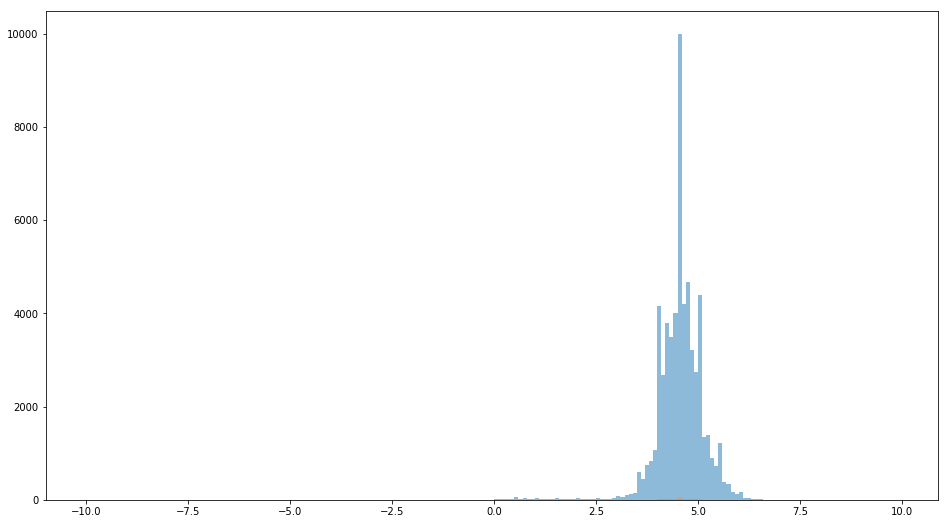

In [244]:
plt.hist(Y_A[ZZ_A==0], bins=np.arange(-10,10,.1), alpha=.5);
plt.hist(Y_A[ZZ_A==1], bins=np.arange(-10,10,.1), alpha=.5);

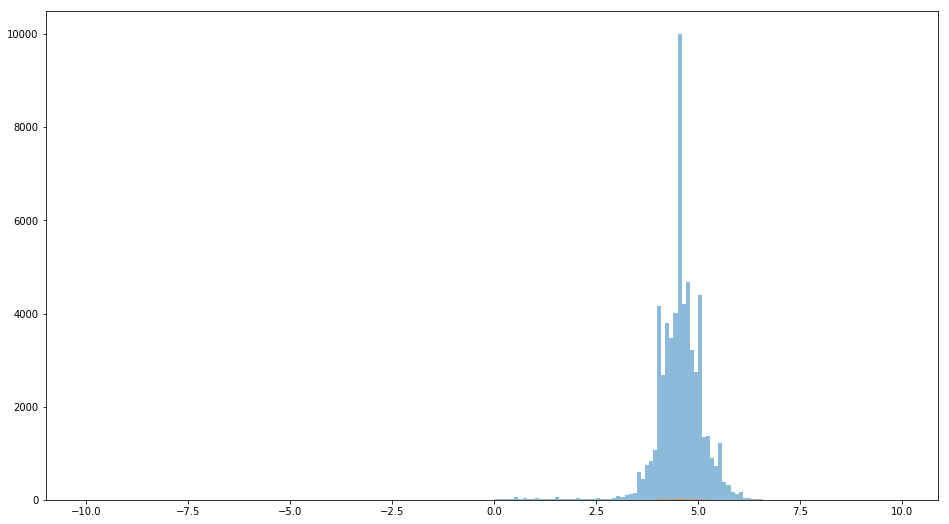

In [245]:
plt.hist(Y_B[ZZ_B==0], bins=np.arange(-10,10,.1), alpha=.5);
plt.hist(Y_B[ZZ_B==1], bins=np.arange(-10,10,.1), alpha=.5);

In [247]:
def wald_instrument_connectivity(
    x, y, stim_times, x1, x2, y1, y2, z1):
    
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    X = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    Y = ((Y > y1) & (Y < y2)).astype(int)
    Z = (abs(Z) < z1).astype(int)
    assert X[Z==1].sum() == 0
    print(Y[Z==1].mean(), Y[Z==0].mean(), X[Z==1].mean(), X[Z==0].mean())
    return (Y[Z==1].mean() - Y[Z==0].mean()) / (X[Z==1].mean() - X[Z==0].mean())


# def wald_instrument_connectivity(
#     x, y, stim_times, x1, x2, y1, y2, z1):
#     stim_times = stim_times.astype(float)

#     src_x = np.searchsorted(x, stim_times, side='right')
#     remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
#     src_x = np.delete(src_x, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)
#     Z = x[src_x-1] - stim_times

#     stim_win = np.insert(
#         stim_times + y1,
#         np.arange(len(stim_times)) + 1,
#         stim_times + y2)
#     src_y = np.searchsorted(y, stim_win, side='left')
#     cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
#     Y = cnt_y.flatten() / (y2-y1)
    
#     stim_win = np.insert(
#         stim_times + x1,
#         np.arange(len(stim_times)) + 1,
#         stim_times + x2)
#     src_x = np.searchsorted(x, stim_win, side='left')
#     cnt_x = np.diff(src_x.reshape((int(len(src_x) / 2), 2)))
#     X = cnt_x.flatten() / (x2 - x1)

#     Z = (abs(Z) < z1).astype(int)
#     assert X[Z==1].sum() == 0
#     print(Y[Z==1].mean(), Y[Z==0].mean(), X[Z==1].mean(), X[Z==0].mean())
#     return (Y[Z==1].mean() - Y[Z==0].mean()) / (X[Z==1].mean() - X[Z==0].mean())

wald_instrument_connectivity(A, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 1)

0.7701149425287356 0.8345258750483947 0.0 0.6407748892298427


0.10052037556758135

In [248]:
wald_instrument_connectivity(B, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 1)

0.7790697674418605 0.8344899773450718 0.0 0.6695965128616902


0.08276657485320374

In [262]:
wald_density(A, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 1)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


0.03565056361427176

In [263]:
wald_density(B, C, stim_data['epoch']['times'], 1.1, 3.1, 3.1, 6.1, 1)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


0.013297959799669383

In [268]:
###############################
# iv_params = {
#     'x_mu': 2,
#     'x_sigma': 1,
#     'y_mu': 5,
#     'y_sigma': 5,
# #     'n_bases': 20,
# #     'bin_size': .1,
# #     'offset': 1e-3,
#     'cutoff': 1
# }

iv_params = {
    'x1': 1.1,
    'x2': 3.1,
    'y1': 3.1,
    'y2': 6.1,
#     'n_bases': 20,
#     'bin_size': .1,
#     'offset': 1e-3,
    'z1': 1
}

# iv_params = {
#     'x_mu': 2,
#     'x_sigma': 2,
#     'y_mu': 5,
#     'y_sigma': 5,
#     'n_bases': 20,
#     'bin_size': .01,
#     'offset': 1e-3
# }

conn_func = wald_density
# conn_func = continuous_connectivity
# conn_func = logit_instrument_connectivity
# conn_func = causal_connectivity
# conn_func = logit_connectivity
# conn_func = wald_instrument_connectivity
# conn_func = cond_prob_connectivity
###############################

sources, targets = sample.loc[:, ['source', 'target']].to_numpy().T

assert len(sources) + len(targets) == N

results_mn = defaultdict(list)
pbar = tqdm(total=int(N / 2)**2 * len(trials))
for N_trials in trials:
    stim_times = stim_data['epoch']['times'][:N_trials + 1]
    period = np.min(np.diff(stim_times))
    t_stop = stim_times[-1] + period
    for source in sources:
        for target in targets: #NOTE different latency in inhibitory neurons
            if target == source:
                continue
            pbar.update(1)
            source_t = spiketrains_ex.get_group(source)['times'].to_numpy()
            target_t = spiketrains_ex.get_group(target)['times'].to_numpy()
            source_t, target_t = source_t[source_t <= t_stop], target_t[target_t <= t_stop]
            
            iv = conn_func(
                source_t, target_t, stim_times, **iv_params)
            
            iv_baseline = conn_func(
                source_t, target_t, stim_times - 10, **iv_params)
        
            stim_amp = float(stim_data['stim_amps']['ex'][source])
            # cc, cv and stuff
            w = conn.query("source=={} and target=={}".format(source, target)).weight
            n_syn = len(w)
#             _hit_rate = hit_rate(
#                 source_t, stim_times, iv_params['x_mu'], iv_params['x_sigma'])
            
            results_mn['iv'].append(iv)
            results_mn['iv_baseline'].append(iv_baseline)
            results_mn['weight'].append(w.sum())
            results_mn['stim_amp'].append(stim_amp)
#             results_mn['hit_rate'].append(_hit_rate)
            results_mn['source'].append(source)
            results_mn['target'].append(target)
            results_mn['n_syn'].append(n_syn)
pbar.close()
results_mn = pd.DataFrame(results_mn)

HBox(children=(IntProgress(value=0, max=625), HTML(value='')))

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [269]:
sum(np.isnan(results_mn.iv)) / len(results_mn.iv) * 100

0.0

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


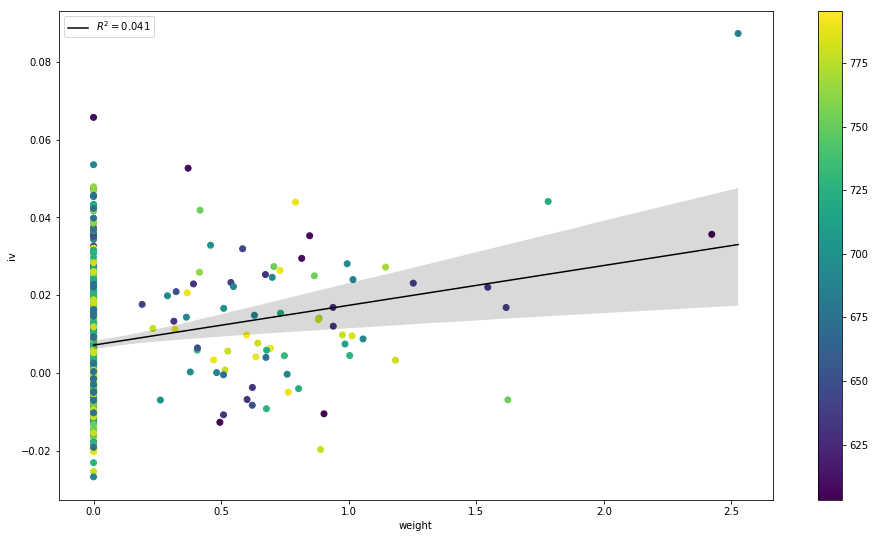

In [270]:
df = results_mn.dropna()

model = regplot(
    'weight', 'iv', data=df, 
    scatter_color=df['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


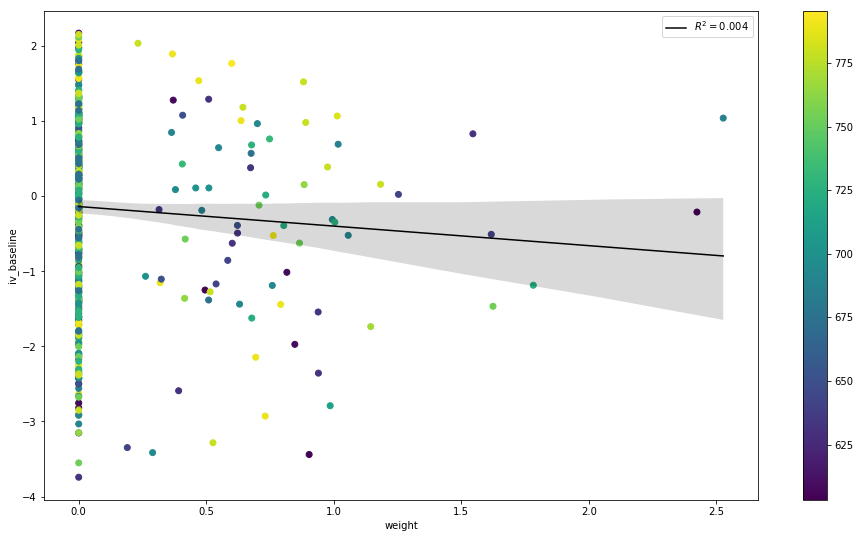

In [271]:
df = results_mn.dropna()

model = regplot(
    'weight', 'iv_baseline', data=df, 
    scatter_color=df['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


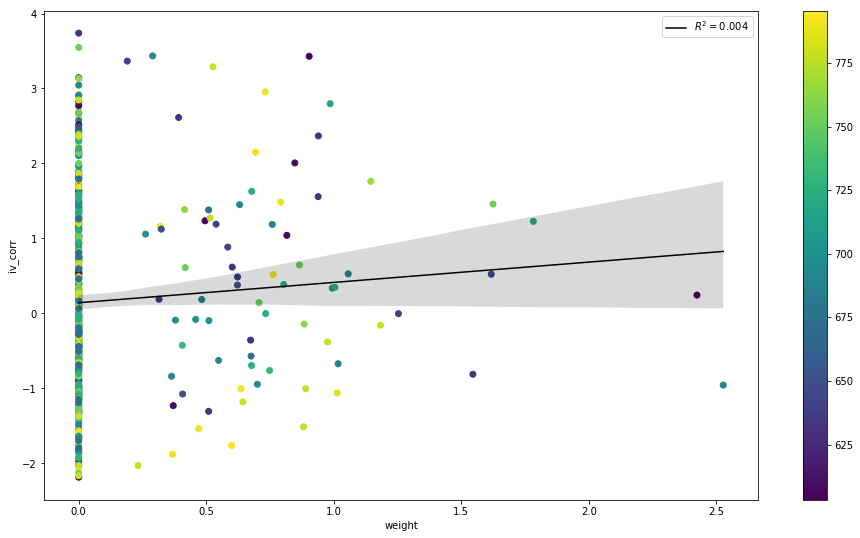

In [272]:
df = results_mn.dropna()
df['iv_corr'] = df.iv - df.iv_baseline

model = regplot(
    'weight', 'iv_corr', data=df, 
    scatter_color=df['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

In [253]:
query = (
    'stim_amp_source > 500 and '
    'stim_amp_source < 900 and '
    'not target_stimulated and '
    'target_ex')
sample = conn.query(query)

In [254]:
sample['classes'] = sample.weight.round(1)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [255]:
sample.groupby('classes')['weight'].nunique()

classes
0.1      29
0.2     899
0.3    3563
0.4    6107
0.5    7078
0.6    6676
0.7    5493
0.8    4374
0.9    3027
1.0    2184
1.1    1582
1.2    1170
1.3     802
1.4     495
1.5     354
1.6     261
1.7     182
1.8     127
1.9      83
2.0      76
2.1      44
2.2      29
2.3      20
2.4      10
2.5      15
2.6       9
2.7       8
2.8       6
2.9       1
3.0       1
3.1       2
3.5       1
4.5       1
Name: weight, dtype: int64

In [259]:
sample = sample.query('weight < 2.2').groupby('classes').progress_apply(lambda x: x.sample(10))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

In [260]:
sample.head(15)

weight  source  target  source_stimulated  target_stimulated  \
classes                                                                       
0.1     426  0.143281     344    1999               True              False   
        347  0.149807     266    3010               True              False   
        74   0.141300      60    2123               True              False   
        354  0.106798     270    2392               True              False   
        388  0.141911     321    2189               True              False   
        113  0.133792      88    2790               True              False   
        273  0.105838     206    3063               True              False   
        246  0.127925     205    2183               True              False   
        114  0.145784     100    2547               True              False   
        402  0.147466     331    2098               True              False   
0.2     335  0.196696     281    2496               True              False   
        147  0.232815     122    2640               True              False   
        343  0.224218     295    2828               True              False   
        96   0.193146      81    2552               True              False   
        59   0.247942      50    2215               True              False   

             target_ex  stim_amp_source  classes  
classes                                           
0.1     426       True       503.795696      0.1  
        347       True       553.754181      0.1  
        74        True       774.420606      0.1  
        354       True       549.425508      0.1  
        388       True       515.876957      0.1  
        113       True       727.212855      0.1  
        273       True       598.646395      0.1  
        246       True       598.646395      0.1  
        114       True       711.686301      0.1  
        402       True       511.819501      0.1  
0.2     335       True       540.857704      0.2  
        147       True       686.134819      0.2  
        343       True       532.409956      0.2  
        96        True       737.632344      0.2  
        59        True       790.281436      0.2

In [275]:
# def calc_density(x, y, stim_times, x1, x2, y1, y2, z1):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
#     XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
#     YY = ((Y > y1) & (Y < y2)).astype(int)
#     ZZ = (abs(Z) < z1).astype(int)
#     assert sum(XX[ZZ==1]) == 0
#     binsize = .1
#     bins = np.arange(0, 25, binsize)
#     X0, _ = np.histogram(X[ZZ==0], bins=bins, density=True)
#     X1, _ = np.histogram(X[ZZ==1], bins=bins, density=True)
#     Y0, _ = np.histogram(Y[ZZ==0], bins=bins, density=True)
#     Y1, _ = np.histogram(Y[ZZ==1], bins=bins, density=True)
#     bins = bins[:-1] + binsize / 2
#     mask_y = (bins >= y1) & (bins <= y2)
#     mask_x = (bins >= x1) & (bins <= x2)
#     ev = lambda x: np.trapz(x, dx=binsize)
    
#     Y1 = ev(Y1[mask_y]) / len(mask_y)
#     Y0 = ev(Y0[mask_y]) / len(mask_y)
#     X0 = ev(X0[mask_x]) / len(mask_y)
#     return Y1, Y0,  X0 

# def wald_density(x, y, stim_times, x1, x2, y1, y2, z1):
#     y11, y10, x10 = calc_density(x, y, stim_times, x1, x2, y1, y2, z1)
#     y21, y20, x20 = calc_density(x, y, stim_times - 25, x1, x2, y1, y2, z1)
#     return ((y11 - y21) - (y10 - y20)) / -(x10 - x20)

# def wald_density(x, y, stim_times, x1, x2, y1, y2, z1):
#     y11, y10, x10 = calc_density(x, y, stim_times, x1, x2, y1, y2, z1)
#     return (y10 - y11) / x10

import scipy.stats as st
def wald_density(x, y, stim_times, x1, x2, y1, y2, z1, limit=10):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_y==len(y)))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Y = y[src_y] - stim_times
    Z = x[src_x-1] - stim_times
    
    XX = ((X > x1) & (X < x2)).astype(int)
    ZZ = (abs(Z) < z1).astype(int)
    assert sum(XX[ZZ==1]) == 0
    
    X0 = X[ZZ==0]
    Y0 = Y[ZZ==0]
    Y1 = Y[ZZ==1]
    
    try:
        KX0 = st.gaussian_kde(X0[X0 < limit], .01)
        KY0 = st.gaussian_kde(Y0[Y0 < limit], .01)
        KY1 = st.gaussian_kde(Y1[Y1 < limit], .01)
    except ValueError:
        return np.nan
    
    X10 = KX0.integrate_box_1d(x1, x2)
    Y11 = KY1.integrate_box_1d(y1, y2)
    Y10 = KY0.integrate_box_1d(y1, y2)
    
    return (Y10 - Y11) / X10

def cond_prob(x, y, stim_times, x1, x2, y1, y2, z1):
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    YY = ((Y > y1) & (Y < y2)).astype(int)
    return YY[XX==1].mean() - YY[XX==0].mean()

In [276]:
iv_params = {
    'x1': 1.1,
    'x2': 3.1,
    'y1': 3.1,
    'y2': 6.1,
#     'n_bases': 20,
#     'bin_size': .1,
#     'offset': 1e-3,
    'z1': 1
}

def calc_iv(row):
    
    source_t = spiketrains_ex.get_group(row.source)['times'].to_numpy()
    target_t = spiketrains_ex.get_group(row.target)['times'].to_numpy()
    stim_times = stim_data['epoch']['times']

    iv = wald_density(
        source_t, target_t, stim_times, **iv_params)
    
    cond = cond_prob(
        source_t, target_t, stim_times, **iv_params)
    
    cond_baseline = cond_prob(
        source_t, target_t, stim_times - 15, **iv_params)

    iv_baseline = wald_density(
        source_t, target_t, stim_times - 15, **iv_params)

    w = conn.query("source=={} and target=={}".format(row.source, row.target)).weight
    n_syn = len(w)

    return iv, iv_baseline, w.sum(), cond, cond_baseline

In [277]:
sample['iv'], sample['iv_baseline'], sample['w_tot'], sample['cond'], sample['cond_baseline'] = zip(
    *sample.progress_apply(calc_iv, axis=1))

print(sample.w_tot.max())

HBox(children=(IntProgress(value=0, max=220), HTML(value='')))


3.386062400667284


/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


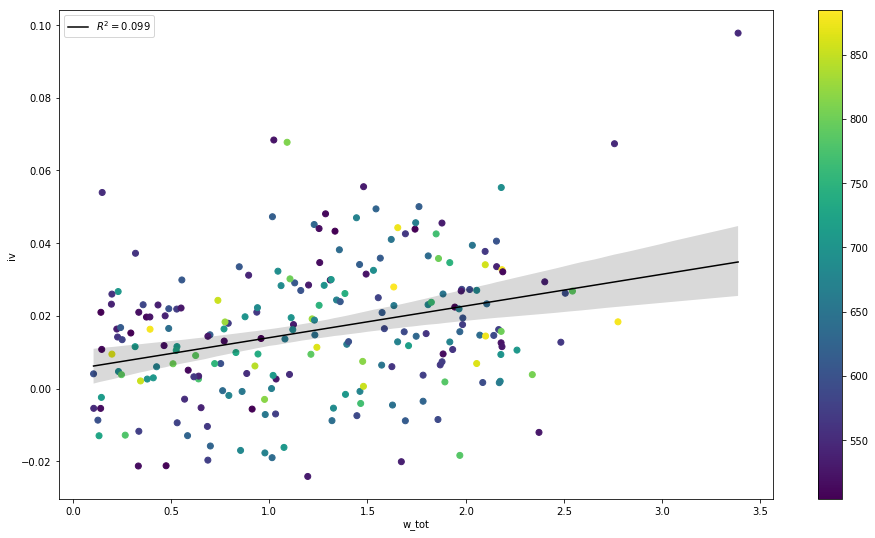

In [278]:
df = sample

model = regplot(
    'w_tot', 'iv', data=df, 
    scatter_color=df['stim_amp_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


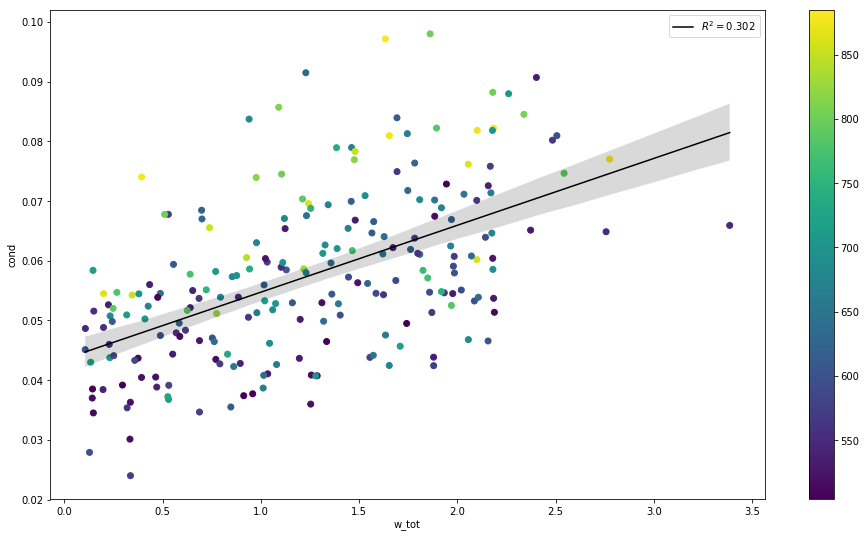

In [270]:
df = sample

model = regplot(
    'w_tot', 'cond', data=df, 
    scatter_color=df['stim_amp_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


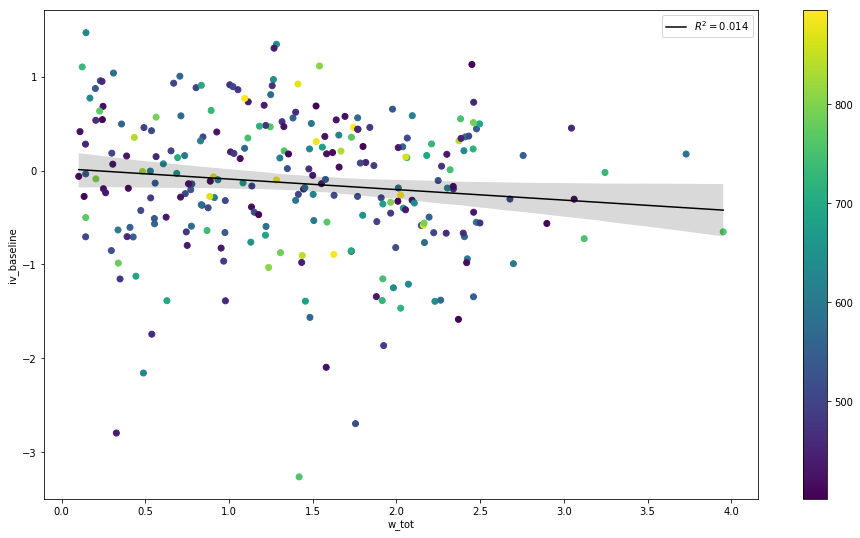

In [227]:
df = sample

model = regplot(
    'w_tot', 'iv_baseline', data=df, 
    scatter_color=df['stim_amp_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


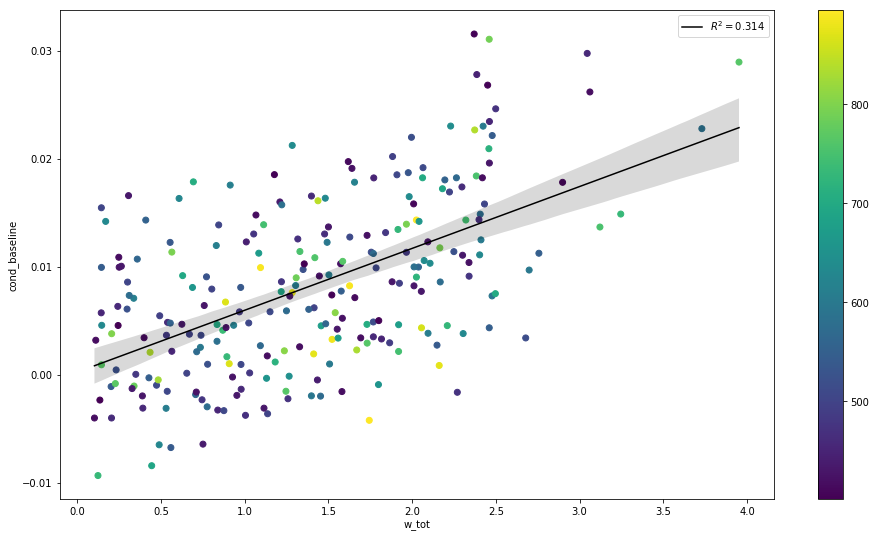

In [228]:
df = sample

model = regplot(
    'w_tot', 'cond_baseline', data=df, 
    scatter_color=df['stim_amp_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

In [50]:
def validate_instrument(source, target, stim_times):
    x = spiketrains_ex.get_group(source)['times'].to_numpy()
    y = spiketrains_ex.get_group(target)['times'].to_numpy()
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_x==0) | (src_y==len(y)) | (src_y==0))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x-1] - stim_times
    Y = y[src_y-1] - stim_times
    
    plt.scatter(X, Y)
    plt.title(
        'cov(A,B)={:.5f}, beta={:.5f}'.format(
            np.cov(X, Y)[0,1], 
            np.corrcoef(X, Y)[0,1] * X.std() / Y.std()));
    
    
def score_instrument(source, stim_times, x_mu, x_sigma, n_bases, bin_size, offset, cutoff=None):
    x = spiketrains_ex.get_group(source)['times'].to_numpy()
    
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Z = x[src_x-1] - stim_times

    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma))

    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    N = 60000
    Z_train, Z_test = Z[:N], Z[N:]
    X_train, X_test = X[:N], X[N:]
    
    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(Z_train, X_train)

    return model.score(Z_test, X_test)
    
    

In [57]:
stim_weight_sorted = conn.query('source_stimulated and stim_amp_source > 500').sort_values('weight', ascending=False)
source, target = stim_weight_sorted.iloc[0].loc[['source', 'target']].to_numpy()

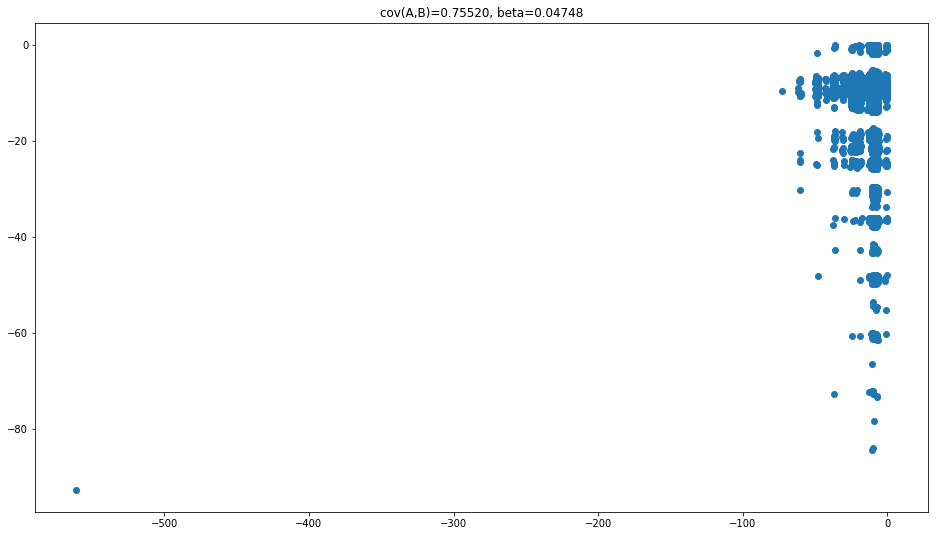

In [64]:
validate_instrument(source, target, stim_data['epoch']['times'])

In [151]:
def lookat_instrument(source, stim_times, x_mu, x_sigma, n_bases, bin_size, offset, cutoff=None):
    x = spiketrains_ex.get_group(source)['times'].to_numpy()
    
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Z = x[src_x-1] - stim_times
    
#     plt.scatter(Z, X)
    
    Z = abs(Z)
    
    Z = (Z < cutoff).reshape(-1,1)

    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma))
    
#     print(sum(X[Z]))

#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
    N = 60000
    Z_train, Z_test = Z[:N], Z[N:]
    X_train, X_test = X[:N], X[N:]
    
    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(Z_train, X_train)

    return model.score(Z_test, X_test)
    
    

In [152]:
len(stim_data['epoch']['times'])

70000

In [154]:
lookat_instrument(source, stim_data['epoch']['times'], 3, 1.5, 20, .1, .0001, 4)

0.7309

In [158]:
tmp = lambda x: lookat_instrument(x, stim_data['epoch']['times'], 2, 1, 20, .1, .0001, 2)

In [159]:
ll = [tmp(source) for source in sample.source]

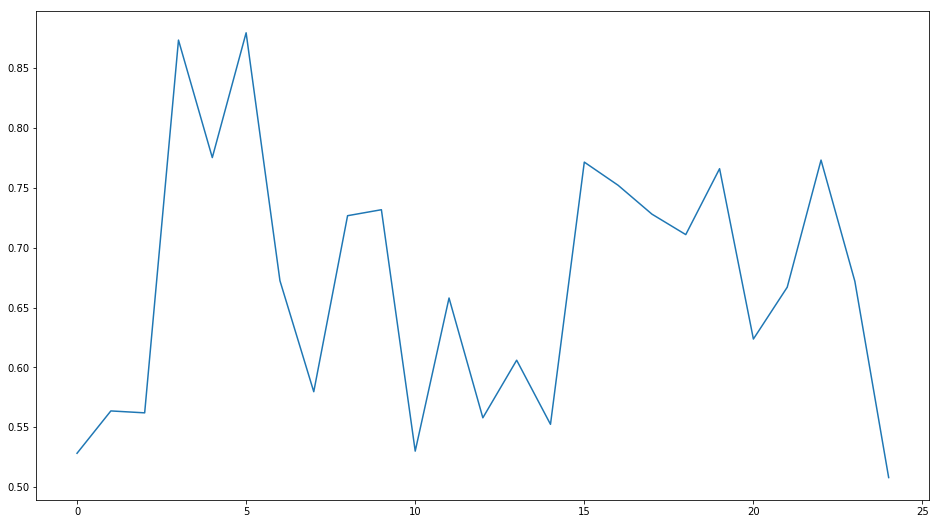

In [160]:
plt.plot(ll)

In [168]:
def score_continuous(
    source, stim_times, n_bases, bin_size, offset):
    x = spiketrains_ex.get_group(source)['times'].to_numpy()
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    model1 = sm.OLS(endog=X, exog=Z)
    res1 = model1.fit()
    
    return res1.rsquared

In [172]:
tmp = lambda x: score_continuous(x, stim_data['epoch']['times'], 200, .1, .0001)

In [173]:
ll = [tmp(source) for source in tqdm(sample.source)]

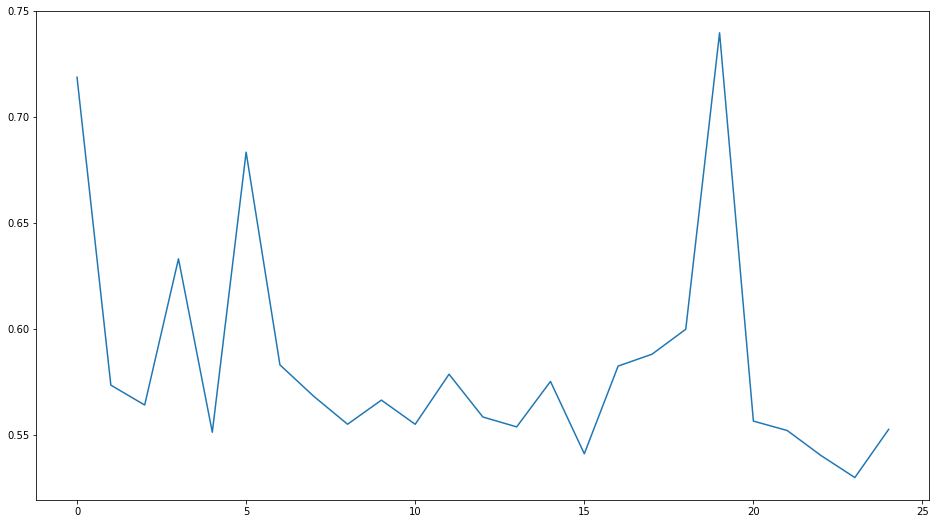

In [174]:
plt.plot(ll)

In [242]:

def continuous_connectivity(
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma):

    Z, X, Y, stim_times = calculate_regressors(x,y,stim_times)
    
    Z = abs(Z)
    Z = (Z < 4)
    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma))
    Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma))
    Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    X = np.vstack((X, np.ones(X.shape[0]))).T
    
    model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
    try:
        res = model.fit()
        beta = res.params[0]
    except:
        beta = np.nan
    return beta

    return beta

continuous_connectivity(
    spiketrains_ex.get_group(source)['times'].to_numpy(), 
    spiketrains_ex.get_group(target)['times'].to_numpy(), 
    stim_data['epoch']['times'], 
    x_mu=2, x_sigma=1, y_mu=4.45, y_sigma=1.5)

0.07799020598253037

In [215]:
regs = defaultdict(list)
pbar = tqdm(total=int(N / 2)**2)
stim_times = stim_data['epoch']['times']

for source in sources:
    for target in targets: #NOTE different latency in inhibitory neurons
        if target == source:
            continue
        pbar.update(1)
        source_t = spiketrains_ex.get_group(source)['times'].to_numpy()
        target_t = spiketrains_ex.get_group(target)['times'].to_numpy()
        Z, X, Y, _ = calculate_regressors(source_t, target_t, stim_times)
        regs['Z'].append(Z)
        regs['X'].append(X)
        regs['Y'].append(Y)
        
pbar.close()

HBox(children=(IntProgress(value=0, max=625), HTML(value='')))

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/mikkel/.virtualenvs/main/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [231]:
x = [t for s in regs['X'] for t in s]

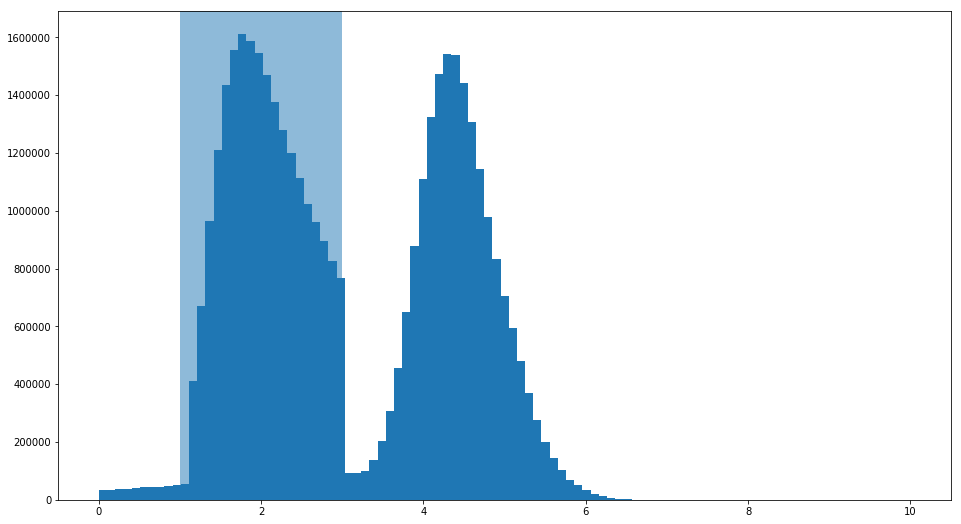

In [235]:
plt.hist(x, bins=np.linspace(0,10,100));
plt.axvspan(1,3, alpha=.5)

In [236]:
y = [t for s in regs['Y'] for t in s]

In [238]:
2.9 / 2 + 3.1

4.55

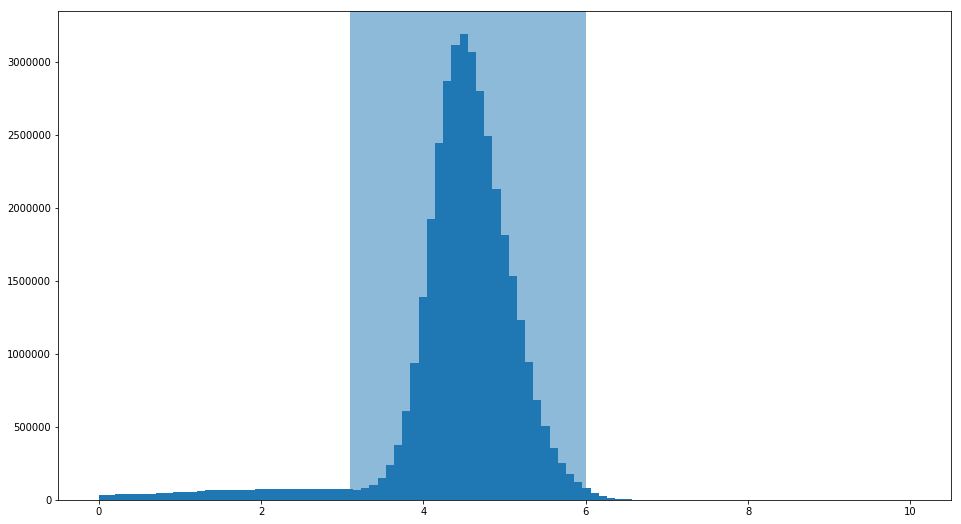

In [237]:
plt.hist(y, bins=np.linspace(0,10,100));
plt.axvspan(3.1, 6, alpha=.5)

In [19]:
import nest

In [56]:
nest.ResetKernel()
A = nest.Create("iaf_psc_alpha", 3)
B = nest.Create("iaf_psc_alpha", 2)
# syn_dict = {'weight': [
#     [1.2, -3.5, 2.5],
#     [0.4, -0.2, 0.7]]}
# nest.Connect(A, B, syn_spec=syn_dict)

# conn_dict = {'rule': 'one_to_one'}
# syn_dict = {'weight': [1.2, -3.5]}
# nest.Connect(A, B, conn_dict, syn_dict)

In [54]:
conns = nest.GetConnections()
conn_include = ('weight', 'source', 'target')
conns = list(nest.GetStatus(conns, conn_include))
conns = pd.DataFrame(conns, columns=conn_include)

In [55]:
conns

,weight,source,target
0,1.2,1,4
1,0.4,1,5
2,-3.5,2,4
3,-0.2,2,5
4,2.5,3,4
5,0.7,3,5


In [45]:
for row in conns.itertuples():
    nest.Connect((row.source,), (row.target,), {'rule': 'one_to_one'}, syn_spec={'weight': [row.weight]})

In [61]:
nest.Connect(conns.source.values, conns.target.values, 
             {'rule': 'one_to_one'}, syn_spec={'weight': conns.weight.values, 'delay': 1})

In [62]:
conns = nest.GetConnections()
conn_include = ('weight', 'source', 'target')
conns = list(nest.GetStatus(conns, conn_include))
conns = pd.DataFrame(conns, columns=conn_include)

In [63]:
conns

,weight,source,target
0,1.2,1,4
1,0.4,1,5
2,0.4,1,5
3,1.2,1,4
4,-0.2,2,5
5,-3.5,2,4
6,-3.5,2,4
7,-0.2,2,5
8,0.7,3,5
9,2.5,3,4
